# Credit Default Problem
**Contributers:**

**Aditya | Divyansh | Himanshu | Sarthak | Tanuja**


In this notebook, we will use the customer tax records to predict whether a customer will default on their loans. 

We have added necessary comments and plots to the code. But the data are synthetic so we have focused more on creating the logic for the model rather than the data.



In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [124]:
def generateSample(n, prior, meanVariances = [[-1,1],[1,1]]):
    # generate a sample of size n from the prior
    # use the mean and variance of the prior to generate the sample
    [class0Mean , class0Variance] = meanVariances[0]
    [class1Mean , class1Variance] = meanVariances[1]
    size1 = int(n * prior)
    size2 = n - size1
    class0Sample = np.random.normal(class0Mean, class0Variance, size1)
    class1Sample = np.random.normal(class1Mean, class1Variance, size2)

    # create a dataframe with the samples and the labels
    df = pd.DataFrame(np.concatenate((class0Sample, class1Sample), axis=0))

    df['label'] = np.concatenate((np.zeros(size1), np.ones(size2))).astype(int)
    
    df.columns = ['X', 'label']
    # shuffle the dataframe
    

    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [125]:
prior = 0.5
sample = generateSample(10000, prior)
sample.head()

,X,label
0,-0.877569,1
1,-1.894296,0
2,-1.353025,0
3,1.558400,1
4,-1.311474,0


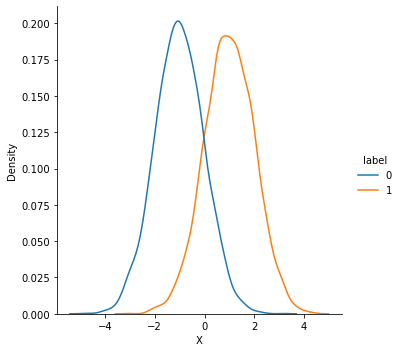

In [126]:
# lets see the synthetic data is generated as expected

# plot the distribution of the data for each class on the same plot
sns.displot(sample, x="X", hue="label", kind="kde")


## Creating a Bayesian classifier

Here we do not have to train the model, because we already know the distribution of the data as the data is synthetic. What we need to do is only classify the data based on the probability we already know.

Basic functioning of a Bayesian classifier is as follows:
\begin{equation}
P(Y|X) = \frac{P(X|Y)P(Y)}{P(X)}
\end{equation}

where,
\begin{equation}
P(X|Y) = P(X=x|Y=y) = N(x;\mu_y,\sigma_y)
\end{equation}



In [127]:
def findBayesianProb(x, prior = 0.5, meanVariances = [[-1,1],[1,1]]):
    # find the probability of the sample x given the prior
    # use the mean and variance of the prior to generate the sample
    [class0Mean , class0Variance] = meanVariances[0]
    [class1Mean , class1Variance] = meanVariances[1]
    # proibabilities are normally distributed
    class0Prob = np.exp(-(x - class0Mean)**2 / (2 * class0Variance)) / np.sqrt(2 * np.pi * class0Variance) * prior
    class1Prob = np.exp(-(x - class1Mean)**2 / (2 * class1Variance)) / np.sqrt(2 * np.pi * class1Variance) * (1 - prior)
    return class0Prob/(class0Prob + class1Prob)

In [128]:
def findBayesianProbBatch(X, prior = 0.5, meanVariances = [[-1,1],[1,1]]):
    # find the probability of the sample X given the prior
    # use the mean and variance of the prior to generate the sample
    [class0Mean , class0Variance] = meanVariances[0]
    [class1Mean , class1Variance] = meanVariances[1]
    result = []
    for x in X:
        # proibabilities are normally distributed
       result.append(findBayesianProb(x, prior, meanVariances))
    return np.array(result)

In [129]:
def classify(x , prior = 0.5, meanVariances = [[-1,1],[1,1]]):
    # classify the sample x based on the prior
    # use the mean and variance of the prior to generate the sample
    # return the label
    prob = findBayesianProb(x, prior, meanVariances)
    return prob < 0.5

In [130]:
def classifyBatch(X, prior = 0.5, meanVariances = [[-1,1],[1,1]]):
    # classify the sample X based on the prior
    # use the mean and variance of the prior to generate the sample
    # return the label
    prob = findBayesianProbBatch(X, prior, meanVariances)
    return prob < 0.5

In [131]:
def findAccuracy(prediction, actual):
    # find the accuracy of the prediction
    # return the accuracy
    return np.sum(prediction == actual)/len(prediction)

In [132]:
prediction = classifyBatch(sample['X'], prior)
actual = sample['label']
accuracy = findAccuracy(prediction, actual)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8445


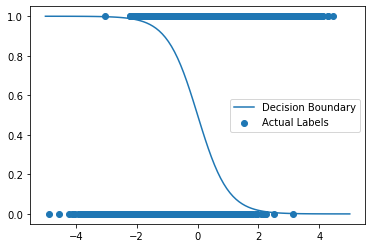

In [133]:
# lets plot the decision boundary and actual labels
boundary = np.linspace(-5, 5, 100)
prob = findBayesianProbBatch(boundary, prior)
# plot both the decision boundary and the actual labels
plt.plot(boundary, prob, label = "Decision Boundary")
plt.scatter(sample['X'], sample['label'], label = "Actual Labels")
plt.legend()
plt.show()


## Adding Randomness to the classifier
Till now we predict the label based on arg max, now we need to add randomness to the classifier. We will add the randomness, what we will do is when we have a probability of a certain label like suppose probability of defaulting is 0.8, we will add a random number between 0 and 1, if the random number is less than 0.8, we will predict defaulting, otherwise we will predict not defaulting.

We have done this step manually wothout any vectorization, to have a better understanding of what is happening.

In [134]:
def predictRandom(x, prior = 0.5, meanVariances = [[-1,1],[1,1]]):
    # predict the label of the sample x based on the prior
    # use the mean and variance of the prior to generate the sample
    # return the label
    prob = findBayesianProb(x, prior, meanVariances)
    
    # add a randomisation to the prediction
    if prob < 0.5:
        # return 1 only with a randomness of 1 - prob
        return np.random.binomial(1, 1 - prob)
    else:
        # return 0 only with a randomness of prob
        return np.random.binomial(1, prob)


def predictRandomBatch(X, prior = 0.5, meanVariances = [[-1,1],[1,1]]):
    # predict the label of the sample X based on the prior
    # use the mean and variance of the prior to generate the sample
    # return the label
    probs = findBayesianProbBatch(X, prior, meanVariances)
    
    # add a randomisation to the prediction
    result = []
    for prob in probs:
        if prob < 0.5:
        # return 1 only with a randomness of 1 - prob
            result.append(np.random.binomial(1, 1 - prob))
        else:
        # return 0 only with a randomness of prob
           result.append(np.random.binomial(0, prob))

    return result

In [135]:
prediction = predictRandomBatch(sample['X'], prior)
actual = sample['label']
accuracy = findAccuracy(prediction, actual)
print(f"Accuracy: {accuracy}")



Accuracy: 0.8128


## Conclusion
Adding randomness to the basian classifier will not improve the expectation of the accurracy of the model, this is because even after getting the high probability for a label there are times when we are not predicting the correct label. This will overall reduce the accuracy of the model. When data set is very small then data can be skewed in such cases we might see a higher accuracy but that would just be accidental and the expectation will always be the less.